# Intro

**PyTorch Geometric (PyG)** is a principal tool for building graph neural network models and experimenting with various graph convolutions. Concurrently, **PyTorch Lightning (PL)** is a prevalent library for automating the learning process of Torch models, monitoring it, and tuning parameters.  
   
While both tools are well-known and frequently utilized, there is a dearth of tutorials demonstrating how to seamlessly integrate them. Although the process is not particularly complicated or different from the separate use of these two libraries, there are minor tweaks and details that users need to be mindful of.  
   
In this tutorial, I will provide an example of how to:  
   
1. Load graph data that will be used in our operations. Our task is link prediction, which answers two questions: which two nodes should be linked with each other?  
2. Prepare the data for modelling by performing a transductive split.  
3. Prepare dedicated graph data loaders for batching.  
4. Build a model and a PyTorch Lightning wrapper around it.  
5. Train the model using the PL Trainer class.  
6. Check the model's performance.  

In [166]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lib install

We will commence with the installation of the necessary libraries. This step is mandatory if you are executing the notebook in a Kaggle or Google Colab environment. Otherwise, you might already have these libraries installed on your system.  

In [167]:
%pip install torch_geometric -q

<div class="alert alert-warning">
For an unknown reason, currently in Kaggle.com notebooks building wheels for torch_scatter and torch sparse takes very long time. This is expected (for now), so be patient.
</div>

In [168]:
%pip install torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html


In [169]:
%pip -q install pytorch_lightning

# Lib imports

Let's import the libraries that we need for this exercise:  
   
1. **Torch** - This general library will assist us in building subclasses and using various utilities.  
2. **Torch Geometric** - This is the primary library for graph neural networks.  
3. **PyTorch Lightning** - This library is used for training, tuning, and validating models.  
4. **Sklearn Metrics and Torchmetrics** - These will be used to check the performance of the model.  
   

In [170]:
import torch_geometric as tg
import torch_geometric.nn as tgnn
import torch as th
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics as tm
import networkx as nx
from pathlib import Path
import json
from sklearn.metrics import classification_report
from typing import Tuple
from tqdm import tqdm, trange
import numpy as np

# Load data

Load Data from inf554 file.

In [5]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]
def load_data_comprehensive():

    root = "./drive/MyDrive/inf554/"
    path_to_training = Path(root + "training")
    path_to_test = Path(root + "test")

    #####
    # training and test sets of transcription ids
    #####
    training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
    training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
    training_set.remove('IS1002a')
    training_set.remove('IS1005d')
    training_set.remove('TS3012c')

    test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
    test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])


    #####
    # text_baseline: utterances are embedded with SentenceTransformer, then train a classifier.
    #####
    startings = []
    y_training = []
    graph = []
    last_graph_size = 0
    with open(root + "training_labels.json", "r") as file:
        training_labels = json.load(file)

    X_training_original = []
    for transcription_id in tqdm(training_set):
        with open(path_to_training / f"{transcription_id}.json", "r") as file:
            transcription = json.load(file)

        with open(path_to_training / f"{transcription_id}.txt", 'r') as file:
            relations = file.readlines()

        graph.extend([(lambda x: (int(x[0]) + last_graph_size, int(x[2]) + last_graph_size, x[1])) (rel.split(' ')) for rel in relations])

        last_graph_size += len(transcription)

        startings.append(len(X_training_original))

        for utterance in transcription:
            X_training_original.append(utterance["speaker"] + ": " + utterance["text"])

        y_training += training_labels[transcription_id]
    return X_training_original, y_training, graph, startings

X, y, graph, startings = load_data_comprehensive()

100%|██████████| 97/97 [00:40<00:00,  2.37it/s]


By default, Torch Geometric datasets can return multiple graphs. However, in our case, we only have one graph to work with.  

In [12]:

def encode_sentences(X):  # Bert
    from transformers import BertTokenizer, BertModel
    # Assuming sentences, relations, and labels are lists and have been defined
    sentences = X  # list of sentences

    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Load pre-trained model (weights)
    model = BertModel.from_pretrained('bert-base-uncased')

    device = th.device('cuda' if th.cuda.is_available() else 'cpu')

    model = model.to(device)

    # Put the model in "evaluation" mode
    model.eval()

    # Batch size
    batch_size = 32

    features = []

    for i in trange(0, len(sentences), batch_size):
        # Tokenize input
        inputs = tokenizer(sentences[i:i+batch_size], return_tensors='pt', padding=True, truncation=True, max_length=512)

        # If a GPU is available, move the inputs to GPU
        inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

        # Predict hidden states features for each layer
        with th.no_grad():
            outputs = model(**inputs)

        # Get the embeddings of the last layer
        last_hidden_states = outputs.last_hidden_state

        # Use the mean of the embeddings as the sentence representation
        sentence_embeddings = th.mean(last_hidden_states, dim=1).squeeze().cpu().numpy()

        # Add features
        features.extend(sentence_embeddings)

    return np.array(features)

X_encoded = encode_sentences(X)



100%|██████████| 2270/2270 [02:57<00:00, 12.79it/s]


In [31]:
from sklearn.preprocessing import OneHotEncoder

categories = {e:i for i, e in enumerate(set(e[2] for e in graph))}
relations_types = [e[2] for e in graph]

encoder = OneHotEncoder(sparse=False)
edge_features = encoder.fit_transform(np.array(relations_types).reshape(-1,1))
edge_features = th.tensor(edge_features, dtype=th.float)

edge_index = th.tensor([(e[0], e[1]) for e in graph])

features = th.stack([th.tensor(x) for x in X_encoded])

data = tg.data.Data(x=features, edge_index=edge_index, edge_attr=edge_features, y=th.tensor(y))



## Links splitting

We will begin by splitting links in our dataset. We will use 20% of graph connections as a validation set and 10% as a test set. We will not add negative samples to the training dataset, as such negative links will be created on-the-fly by the data loader.  
   
The concept of negative sampling is well-known and widely used, especially in natural language processing. To learn more about it, you can read [this excellent post by Chris McCormick](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/).  
   
In general, negative sampling creates "fake" samples (in our case, connections between nodes), so the model learns how to distinguish real connections. Negative sampling has some nice statistical properties, grounded in the theory and mathematics of sampling.  

Ici in va faire notre split de sorte à conserver des dialogues entiers.

In [52]:
limits = np.cumsum(len(startings) * np.array([.6, .15, .25]))
data.train_mask = np.array([i < startings[int(limits[0])] for i in range(data.num_nodes)])
data.test_mask = np.array([startings[int(limits[1])] <= i for i in range(data.num_nodes)])
data.val_mask = np.array([startings[int(limits[0])] <= i < startings[int(limits[1])] for i in range(data.num_nodes)])

In [63]:
data.y = th.tensor(data.y)

<ipython-input-63-3c3fb45df9bb>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y = th.tensor(data.y)


In [36]:
tg.seed_everything(123)

In [ ]:
link_splitter = tg.transforms.RandomLinkSplit(
    num_val=0.2,
    num_test=0.1,
    add_negative_train_samples=False,
    disjoint_train_ratio=0.8)

Data splitting is done as follows:

In [92]:
def sub_graph(graph, mask):
    x = graph.x[mask]
    y = graph.y[mask]
    idx = th.tensor(np.arange(graph.num_nodes)[mask])
    edge_features = []
    edge_index = []
    for feature, index in zip(graph.edge_attr, graph.edge_index):
        if index[0] in idx:
            edge_features.append(feature)
            edge_index.append(index)
    return tg.data.Data(
        x=x,
        edge_attr=th.t(th.stack(edge_features)),
        edge_index=th.t(th.stack(edge_index)),
        y=y
    )
# t = sub_graph(data, data.train_mask)

# len((data.y)[data.val_mask]) / len(data.x)

In [171]:
# len(t.x), len(t.y)
root = "./drive/MyDrive/inf554/"
def save():
    with open(root + 'features.npy', 'wb') as f:
        np.save(f, data.x.cpu().numpy())
        np.save(f, data.y.cpu().numpy())
        np.save(f, data.edge_attr.cpu().numpy())
        np.save(f, data.edge_index.cpu().numpy())

        np.save(f, train_g.x.cpu().numpy())
        np.save(f, train_g.y.cpu().numpy())
        np.save(f, train_g.edge_attr.cpu().numpy())
        np.save(f, train_g.edge_index.cpu().numpy())

        np.save(f, test_g.x.cpu().numpy())
        np.save(f, test_g.y.cpu().numpy())
        np.save(f, test_g.edge_attr.cpu().numpy())
        np.save(f, test_g.edge_index.cpu().numpy())

        np.save(f, val_g.x.cpu().numpy())
        np.save(f, val_g.y.cpu().numpy())
        np.save(f, val_g.edge_attr.cpu().numpy())
        np.save(f, val_g.edge_index.cpu().numpy())

def load():
    data = tg.data.Data()
    train_g = tg.data.Data()
    test_g = tg.data.Data()
    val_g = tg.data.Data()
    with open(root + 'features.npy', 'rb') as f:
        data.x = th.tensor(np.load(f))
        data.y = th.tensor(np.load(f))
        data.edge_attr = th.tensor(np.load(f))
        data.edge_index = th.tensor(np.load(f))

        train_g.x = th.tensor(np.load(f))
        train_g.y = th.tensor(np.load(f))
        train_g.edge_attr = th.tensor(np.load(f))
        train_g.edge_index = th.tensor(np.load(f))

        test_g.x = th.tensor(np.load(f))
        test_g.y = th.tensor(np.load(f))
        test_g.edge_attr = th.tensor(np.load(f))
        test_g.edge_index = th.tensor(np.load(f))

        val_g.x = th.tensor(np.load(f))
        val_g.y = th.tensor(np.load(f))
        val_g.edge_attr = th.tensor(np.load(f))
        val_g.edge_index = th.tensor(np.load(f))

    return data, train_g, test_g, val_g

In [207]:
data, train_g, test_g, val_g = load()

In [185]:
test_g.edge_index.size()

torch.Size([2, 23196])

In [208]:
## Update edge indexes
test_g.edge_index = test_g.edge_index - th.min(test_g.edge_index)
val_g.edge_index = val_g.edge_index - th.min(val_g.edge_index)

In [131]:
train_g = sub_graph(data, data.train_mask)
test_g  = sub_graph(data, data.test_mask)
val_g   = sub_graph(data, data.val_mask)

NameError: ignored

In [209]:
val_g.edge_attr = th.t(val_g.edge_attr)
train_g.edge_attr = th.t(train_g.edge_attr)
test_g.edge_attr = th.t(test_g.edge_attr)

We have some new attributes:  
   
1. Edge label - that describes if the edge is true/fake. **This is what we want to predict**.  
2. Edge label index - 2 x NUM EDGES matrix, that stores node connections.  
   
Let's investigate the distribution of positive and negative samples.

In [210]:
train_g.y

tensor([0, 0, 1,  ..., 0, 0, 1])

In [10]:
th.unique(train_g.y, return_counts=True)

(tensor([0, 1]), tensor([32265,  8043]))

In [19]:
th.unique(val_g.y, return_counts=True)

(tensor([0, 1]), tensor([7586, 1508]))

In [21]:
th.unique(val_g.y, return_counts=True)

(tensor([0, 1]), tensor([7586, 1508]))

# Model

## GNN module

Now it is time to build a GNN part of our model - the one that will be responsible for generating graph embeddings.  
   
This is a typical `torch.nn.Module` with graph convolutions from PyG.  

In [189]:
class GNN(nn.Module):

    def __init__(
        self,
        dim_in: int,
        conv_sizes: Tuple[int, ...],
        act_f: nn.Module = th.relu,
        dropout: float = 0.1,
        *args,
        **kwargs):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = conv_sizes[-1]
        self.dropout = dropout
        self.act_f = act_f
        last_in = dim_in
        layers = []

        # Here we build subsequent graph convolutions.
        for conv_sz in conv_sizes:
            conv = tgnn.GATConv(in_channels=last_in, out_channels=conv_sz, edge_dim = 16, *args, **kwargs)
            last_in = conv_sz
            layers.append(conv)
        self.layers = nn.ModuleList(layers)

    def forward(self, x: th.Tensor, edge_index: th.Tensor, edge_attr: th.Tensor) -> th.Tensor:
        h = x
        for conv in self.layers:
            h = conv(h, edge_index, edge_attr)
            h = self.act_f(h)
            if self.dropout:
                h = nn.functional.dropout(h, p=self.dropout, training=self.training)
        return h

In [199]:
data.edge_attr.size()

torch.Size([72526, 16])

Notable part of this model is set of graph convolutions - in our case `SAGEConv`. Formally SAGE convolution is defined as:  
   
$$  
\begin{align*}  
h_{\mathcal{N}(v)}^k &\leftarrow AGG\big(\{ h_u^{l-1}, \forall u \in N(v)\}\big) \\[1em]  
h_v^l &\leftarrow \sigma\bigg(W^l \cdot CONCAT\big(h_v^{l-1}, AGG\big(\{ h_u^{l-1}, \forall u \in N(v)\}\big) \big)\bigg)  
\end{align*}  
$$  
   
With $v$ being a current node, and $\mathcal{N}(v)$ - neighbors of node v.  
   
To know more about this convolution type, check the original paper of GraphSAGE:  
   
> Hamilton, W., Ying, Z., & Leskovec, J. (2017). Inductive representation learning on large graphs. Advances in neural information processing systems, 30.  
   
Available through Arxiv: https://arxiv.org/abs/1706.02216  
   
Let's check if our model can make predictions using the data, that we have prepared. Notice, one fact: **PyG models accept matrix of node features X and edge_index - defining connections**.  
   

In [198]:
train_g.x.size()[1],

(768,)

In [211]:
gnn = GNN(val_g.x.size()[1], conv_sizes=[3, 6, 3])
with th.no_grad():
    out = gnn(val_g.x,val_g.edge_index, val_g.edge_attr)

out.size()

torch.Size([9094, 3])

The output from our model is a **matrix of node embeddings** of dimension: `N nodes x Embed size`.  

## PyTorch Lightning Wrapper  
   
Now it is time to define our PL wrapper around the graph convolution. This model will contain the following elements:  
   
1. **"Inner graph convolution"** - the part that we have defined so far. The Graph convolution part returns node embeddings.  
2. **Link prediction layer** - this layer will take the source node embeddings (message senders) and target node embeddings (message receivers) and compute a product between them and then add some non-linearity. This will assist the model in deciding whether there should be a link or not.  

In [128]:
class GDPModel(torch.nn.Module):
    def __init__(self, num_features=3, hidden_size=32, target_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.convs = [GATConv(self.num_features, self.hidden_size, edge_dim = NUM_EDGE_FEATURES),
                      GATConv(self.hidden_size, self.hidden_size, edge_dim = NUM_EDGE_FEATURES)]
        self.linear = nn.Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr) # adding edge features here!
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr) # edge features here as well
        x = self.linear(x)

        return F.relu(x)

NameError: ignored

In [ ]:

def train(model, name_prefix, hyperparams):
    '''
    Train model with given hyperparams dict.
    Saves the following CSVs over the course of training:
    1. the loss trajectory: the val and train loss every save_loss_interval epochs at
       filename 'results/{name_prefix}_{learning_rate}_train.csv' e.g. 'results/baseline_0.05_train.csv'
    2. every save_model_interval save both the model at e.g. 'models/baseline_0.05_0_out_of_1000.pt`
       and the predicted values vs actual values in `results/baseline_0.05_0_out_of_1000_prediction.csv' on the test data.
    '''
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    n_epochs = hyperparams['n_epochs']
    save_loss_interval = hyperparams['save_loss_interval']
    print_interval = hyperparams['print_interval']
    save_model_interval = hyperparams['save_model_interval']

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    losses = []
    test_data = data_test[0]
    for epoch in range(n_epochs):
        epoch_loss = 0
        model.train()
        for data in loader:
            optimizer.zero_grad()
            out = model(data)
            loss = F.mse_loss(out, data.y)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        if epoch % save_loss_interval == 0:
            val_loss = evaluate_model(model, data_val) / NUM_VAL
            train_loss = epoch_loss / NUM_TRAIN * batch_size
            if epoch % print_interval == 0:
                print("Epoch: {} Train loss: {:.2e} Validation loss: {:.2e}".format(epoch, train_loss, val_loss))
            losses.append((epoch, train_loss, val_loss))
        if epoch % save_model_interval == 0:
            # save predictions for plotting
            model.eval()

    return losses

In [237]:
class LinkPredModel(pl.LightningModule):

    def __init__(
        self,
        dim_in: int,
        conv_sizes: Tuple[int, ...],
        act_f: nn.Module = th.relu,
        dropout: float = 0.1,
        lr: float = 0.01,
        *args, **kwargs):
        super().__init__()

        # Our inner GNN model
        self.gnn = GNN(dim_in, conv_sizes=conv_sizes, act_f=act_f, dropout=dropout)

        # Final prediction model on links.
        self.lin_pred = nn.Linear(self.gnn.dim_out, 1)
        self.lr = lr

    def forward(self, x: th.Tensor, edge_index: th.Tensor, edge_attr: th.Tensor) -> th.Tensor:
        # Step 1: make node embeddings using GNN.
        h = self.gnn(x, edge_index, edge_attr)
        # Take source nodes embeddings- senders
        h_src = h[edge_index[0, :]]
        # Take target node embeddings - receivers
        h_dst = h[edge_index[1, :]]

        # Calculate the product between them
        # src_dst_mult = h_src * h_dst
        # Apply non-linearity
        out = self.lin_pred(h)

        # print(out.size(), x.size())

        return out #th.sigmoid(out)

    def _step(self, batch: th.Tensor, phase: str='train') -> th.Tensor:
        yhat_edge = self(batch.x, batch.edge_index, batch.edge_attr).squeeze()
        y = batch.y.to(th.float32)
        loss = nn.functional.binary_cross_entropy_with_logits(input=yhat_edge, target=y, pos_weight = th.tensor([7.0]))
        f1 = tm.functional.f1_score(preds=yhat_edge, target=y, task='binary')
        prec = tm.functional.precision(preds=yhat_edge, target=y, task='binary')
        recall = tm.functional.recall(preds=yhat_edge, target=y, task='binary')

        # Watch for logging here - we need to provide batch_size, as (at the time of this implementation)
        # PL cannot understand the batch size.
        self.log(f"{phase}_f1", f1, batch_size=5)
        self.log(f"{phase}_loss", loss, batch_size=5)
        self.log(f"{phase}_precision", prec, batch_size=5)
        self.log(f"{phase}_recall", recall, batch_size=5)

        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch)

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")

    def predict_step(self, batch):
        x, edge_index, edge_attr = batch
        return self(x, edge_index, edge_attr)

    def configure_optimizers(self):
        return th.optim.Adam(self.parameters(), lr=self.lr)

The code above is a typical "boilerplate" from Pytorch Lightning with two exceptions:  
1. **Forward loop** - contains two steps: node embeddings using GNN and link prediction.  
2. **Logging with batch size** - currently PL cannot understand the batch size from graph data, so we need to instruct it, providing the dimensionality of **edge_label_index** - the number of labeled connections in our batch.  
   
Again, we can check if the model works at all.  

In [231]:
model = LinkPredModel(val_g.x.size()[1], conv_sizes=[3, 6, 3])
with th.no_grad():
    out = model.predict_step((val_g.x, val_g.edge_index, val_g.edge_attr))
out.size(), out

(torch.Size([9094, 1]),
 tensor([[0.4330],
         [0.4292],
         [0.4204],
         ...,
         [0.3195],
         [0.3488],
         [0.3266]]))

# Training the Model  
   
Now it is time for a training loop. Again, no surprises here, with one exception: **special data loaders**.  
   
Graph data requires special treatment - especially for link prediction. PyG has some specialized data loader classes, that are responsible for properly generating batches.  
In our case, we will use: `tg.loader.LinkNeighborLoader` that takes the following inputs:  
   
1. The data (graph) to be loaded in batches.  
2. `num_neighbors` - maximum number of neighbors of each node to be loaded during one "hop". A list specifying the number of neighbors one-two-three-...-K hops away. Especially useful for very large graphs.  
3. `edge_label_index` - which attribute (is any) already indicates true/fake connections.  
4. `neg_sampling_ratio` - proportion of negative samples to real ones.  
   

In [ ]:
data.batch =

In [228]:

# Define a custom collate function to batch the sampled data
def collate(samples):
    return samples[0]  # In this example, we just return the first sampled batch

# Create a PyTorch DataLoader using the sampler and collate function
train_loader = tg.loader.DataLoader([train_g], batch_size=64, shuffle=True, collate_fn=collate, num_workers=2)
test_loader = tg.loader.DataLoader([test_g], batch_size=64, collate_fn=collate, num_workers=2)
val_loader = tg.loader.DataLoader([val_g], batch_size=64, collate_fn=collate, num_workers=2)

# # Now you can iterate through train_loader for node-wise training
# for data_flow in train_loader:
#     # Perform your training with the sampled node data (data_flow)
#     # Your training code goes here
#     pass  # Remove this line when you add your training code

Now it is time for a typical, boilerplate trianing loops with PL.

In [238]:
model = LinkPredModel(val_g.x.size()[1], conv_sizes=[16, 8])
trainer = pl.Trainer(max_epochs=10, log_every_n_steps=1)

# Validate before training - we will see results of untrained model.
trainer.validate(model, val_loader)

# Train the model
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │            0.0            │
│         val_loss          │     1.424164891242981     │
│       val_precision       │            0.0            │
│        val_recall         │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type   | Params
------------------------------------
0 | gnn      | GNN    | 12.9 K
1 | lin_pred | Linear | 9     
------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.052     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [233]:
# Check the model after training
trainer.validate(model, val_loader)

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │    0.3879350423812866     │
│         val_loss          │    0.8021143078804016     │
│       val_precision       │    0.29835832118988037    │
│        val_recall         │    0.5543766617774963     │
└───────────────────────────┴───────────────────────────┘

[{'val_f1': 0.3879350423812866,
  'val_loss': 0.8021143078804016,
  'val_precision': 0.29835832118988037,
  'val_recall': 0.5543766617774963}]

In [ ]:
%pip install pyg-lib torch-sparse

In [ ]:
%pip install pyg-lib -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

In [ ]:
%pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Check the model performance on test set.

In [234]:
trainer.test(model, test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.37121137976646423    │
│         test_loss         │    0.7977136373519897     │
│      test_precision       │    0.2943018078804016     │
│        test_recall        │    0.5025394558906555     │
└───────────────────────────┴───────────────────────────┘

[{'test_f1': 0.37121137976646423,
  'test_loss': 0.7977136373519897,
  'test_precision': 0.2943018078804016,
  'test_recall': 0.5025394558906555}]

# Test data check

We can now run a final check on the test data - to see the classification report and ROC AUC curve.  


In [236]:
with th.no_grad():
    yhat_test_proba = th.sigmoid(model(test_g.x, test_g.edge_index, test_g.edge_attr)).squeeze()
    yhat_test_cls = yhat_test_proba >= 0.5

print(classification_report(y_true=test_g.y, y_pred=yhat_test_cls))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81     19480
           1       0.28      0.51      0.36      3741

    accuracy                           0.71     23221
   macro avg       0.59      0.63      0.59     23221
weighted avg       0.79      0.71      0.74     23221



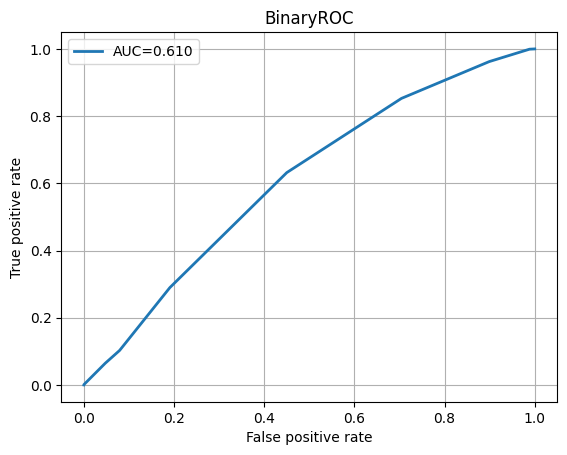

In [225]:
binary_roc = tm.classification.BinaryROC(thresholds=20)
binary_roc(yhat_test_proba, test_g.y.to(th.long))
fig_, ax_ = binary_roc.plot(score=True)


The model we trained here was not particularly complex or carefully tuned, but it gets the job done. Now you can play with it if you want to improve its performance.

# Conclusion


In this tutorial, we have walked through the steps of integrating PyTorch Geometric and PyTorch Lightning to train a graph neural network. We have also delved into some of the nuances that come with using these two powerful libraries together.   
  
In summary, we covered:  
   
1. Loading and processing graph data.  
2. Building a GNN model and integrating it with PyTorch Lightning.  
3. Training the model using custom data loaders that are designed for graph data.  
4. Evaluating the model's performance on a test set.  
   
Despite its apparent complexity, the combination of PyTorch Geometric and PyTorch Lightning provides a good solution for quick prototyping and training graph neural networks. By following the steps laid out in this tutorial, you should be able to utilize these tools effectively in your own projects.